In [16]:
from matplotlib import pyplot as plt
import networkx as nx
from collections import deque, defaultdict
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from copy import deepcopy
from localglobalconsistency import LGC
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
import seaborn as sns


In [17]:
# GBILI

class Gbili:
    """ Algoritmo de construccion de grafos GBILI basado en el artículo:
    'Graph construction based on labeled instances for
    Semi-Supervised Learning' de los autores: 
    Lilian Berton y Alneu de Andrade Lopes
    """

    def __init__(self, datos_se, datos_e, etiquetas, K):
        """
        Constructor de la clase.

        Args:
        - datos_se: numpy.ndarray
            Datos sin etiquetar.
        - datos_e: numpy.ndarray
            Datos etiquetados.
        - etiquetas: numpy.ndarray
            Todas las etiquetas.
        - K: int
            Número de vecinos más cercanos a considerar.

        Inicializa los atributos:
        - nodos: numpy.ndarray
            Todos los nodos (datos reales), tanto etiquetados como sin etiquetar.
        - nodos_etiquetados: numpy.ndarray
            Índices de los nodos etiquetados.
        - nodos_sin_etiquetar: numpy.ndarray
            Índices de los nodos sin etiquetar.
        - K: int
            Número de vecinos más cercanos a considerar.
        - matriz_distancias: numpy.ndarray
            Matriz de distancias entre los nodos.
        - grafo: dict
            Grafo que representa las conexiones entre los nodos.
        - etiquetas_etiquetados: numpy.ndarray
            Etiquetas correspondientes a los nodos etiquetados.
        """

        self.nodos = np.concatenate((datos_e, datos_se), axis=0)
        self.nodos_etiquetados = np.array(range(len(datos_e)))
        self.nodos_sin_etiquetar = np.array(range(len(datos_e), len(datos_e) + len(datos_se)))
        self.K = K
        self.matriz_distancias = distance_matrix(self.nodos, self.nodos)
        self.grafo = {}

        
        self.etiquetas_etiquetados = etiquetas[:len(datos_e)]
        # TODO: borrar
        self.etiquetas_modificadas = np.concatenate((self.etiquetas_etiquetados, np.full(len(datos_se), -1)))
    def construir_grafo(self):
        """
        Indica el proceso de construcción del grafo GBILI.
        Se realizan los siguientes pasos:
        1. Encuentra los k vecinos más cercanos de cada vértice.
        2. Encuentra los pares mutuos de vecinos más cercanos.
        3. Conecta los vértices con la mínima distancia.
        4. Encuentra los componentes del grafo.
        5. Conecta los componentes del grafo basándose en la presencia de etiquetas.

        Returns:
            dict: grafo resultante de la construcción.
        """
        # Configurar la figura y los ejes
        # fig, axs = plt.subplots(2, 2, figsize=(12, 6))  # 2 fila, 2 columnas
        # colores_map = np.array(self.etiquetas_modificadas)

        lista_knn = self.encuentra_knn()
        # self.dibujar_grafo(lista_knn, colores_map, axs[0, 0], "K-NN")

        lista_mknn = self.encuentra_mknn(lista_knn)
        # self.dibujar_grafo(lista_mknn, colores_map, axs[0, 1], "Mutual K-NN")

        self.conectar_minima_distancia(lista_mknn)
        grafo_1 = deepcopy(self.grafo)

        # Componente = subgrafo
        componentes = self.encontrar_componentes()   
        # print("Componentes antes de conectar: ", componentes) 
        self.conectar_componentes(componentes, lista_knn)
        # print("GRAFO CON COMPONENTES CONECTADOS: ", self.grafo)
        # print()
        grafo_2 = deepcopy(self.grafo)
        # print("Componentes despues de conectar: ", self.encontrar_componentes())

        # self.dibujar_grafo(grafo_1, colores_map, axs[1, 0], "Grafo antes de conectar componentes")
        # self.dibujar_grafo(grafo_2, colores_map, axs[1, 1], "Grafo después de conectar componentes")
        # Crear una leyenda
        custom_lines = [Line2D([0], [0], color='yellow', lw=3),
                        Line2D([0], [0], color='blue', lw=3),
                        Line2D([0], [0], color='green', lw=3),
                        Line2D([0], [0], color='grey', lw=3)]

        # fig.legend(custom_lines, ['0', '1', '2', 'Desconocido'])
        # plt.show()
        return self.grafo

    def encuentra_knn(self):
        """ Encuentra los k vecinos más cercanos de cada vértice.
        <<knn>>: `k-nearest neighbors`

        Returns:
            dict: contiene los k vecinos más cercanos de cada vértice.
        """
        n = len(self.nodos)
        lista_knn = {}
        for i in range(n):
            # Guarda una tupla con la distancia y el indice del vertice
            distancias = [(self.matriz_distancias[i][j], j) for j in range(n) if i != j]
            distancias.sort()
            # Seleccionar los K vecinos más cercanos
            lista_knn[i] = [ind_v for _, ind_v in distancias[:self.K]]
        return lista_knn

    def encuentra_mknn(self, lista_knn):
        """ Para los vértices en la lista de k-NN
        encuentra los pares mutuos de vecinos más cercanos.
        Mutuo k-NN: Si i es vecino más cercano de j y 
                    j es vecino más cercano de i.
        Args:
            lista_knn (dict): contiene los k vecinos más cercanos de cada vértice.

        Returns:
            dict: contiene los pares mutuos de vecinos más cercanos.
        """
        lista_mknn = {}
        for i in lista_knn:
            lista_mknn[i] = []
            for j in lista_knn[i]:
                if i in lista_knn[j]:
                    lista_mknn[i].append(j)
        return lista_mknn

    def conectar_minima_distancia(self, lista_mknn):
        """ Conecta los vértices con la mínima distancia.
        Almacena esos enlaces en el diccionario que representa el grafo.
        El grafo es no dirigido, por lo que se conectan ambos nodos.

        Args:
            lista_mknn (dict): contiene los pares mutuos de vecinos más cercanos.
        """
        for i in lista_mknn:
            # Si el nodo no tiene vecinos mutuos, se agregan como elementos solitarios
            if not lista_mknn[i]:
                self.grafo[i] = []
                continue
            for j in lista_mknn[i]:
                min_distancia = float('inf')
                min_enlace = None
                for l in self.nodos_etiquetados:
                    d = self.matriz_distancias[i][j] + self.matriz_distancias[j][l]
                    if d < min_distancia:
                        min_distancia = d
                        min_enlace = (i, j)
            if min_enlace:
                if min_enlace[0] not in self.grafo:
                    self.grafo[min_enlace[0]] = []
                if min_enlace[1] not in self.grafo:
                    self.grafo[min_enlace[1]] = []
                if min_enlace[1] not in self.grafo[min_enlace[0]]:
                    self.grafo[min_enlace[0]].append(min_enlace[1])
                if min_enlace[0] not in self.grafo[min_enlace[1]]:
                    self.grafo[min_enlace[1]].append(min_enlace[0])

    def encontrar_componentes(self):
        """ Encuentra los componentes del grafo.
        Utiliza BFS (Breadth First Search) o busqueda en anchura 
        para encontrar los componentes.

        Returns:
            dict: contiene los componentes del grafo.
        """
        visitados = {}
        componentes = {}
        id_comp = 0

        def bfs(v):
            """Realiza una búsqueda en anchura a partir de un vértice dado.

            Esta función implementa el algoritmo de búsqueda en anchura
            (BFS por sus siglas en inglés) en un grafo. 
            Comienza la búsqueda desde el vértice 'v' y visita todos los 
            vértices alcanzables desde 'v'.

            Args:
                v (int): El vértice de inicio para la búsqueda en anchura.
            """
            cola = deque([v])
            visitados[v] = True
            componentes[v] = id_comp
            while cola:
                actual = cola.popleft()
                for vecino in self.grafo.get(actual, []):
                    if not visitados.get(vecino, False):
                        visitados[vecino] = True
                        componentes[vecino] = id_comp
                        cola.append(vecino)

        for v in range(len(self.nodos)):
            if v not in visitados:
                bfs(v)
                id_comp += 1
        return componentes
 
    def conectar_componentes(self, comp, lista_knn):
        """
        Conecta los componentes del grafo basándose en la presencia de etiquetas.

        Args:
            comp (dict): contiene los componentes del grafo con cada nodo mapeado a su componente.
            lista_knn (dict): contiene los k vecinos más cercanos de cada vértice.
        """
        # Invertir el diccionario de componentes para agrupar nodos por componente
        comp_a_nodos = defaultdict(list)
        for nodo, componente in comp.items():
            comp_a_nodos[componente].append(nodo)

        # Determinar si cada componente tiene nodos etiquetados
        comp_etiquetados = {}
        for componente, nodos in comp_a_nodos.items():
            comp_etiquetados[componente] = any(nodo in self.nodos_etiquetados for nodo in nodos)

        # Conectar componentes según las condiciones dadas
        for v in range(len(self.nodos)):
            componente_v = comp[v]
            # Verificar si la componente de v no tiene nodos etiquetados
            if not comp_etiquetados[componente_v]:
                for vk in lista_knn[v]:
                    componente_vk = comp[vk]
                    # Verificar si la componente de vk tiene nodos etiquetados
                    if comp_etiquetados[componente_vk]:

                        if vk not in self.grafo[v]:
                            self.grafo[v].append(vk)
                        if v not in self.grafo[vk]:
                            self.grafo[vk].append(v)

    def dibujar_grafo(self, grafo, colores_map, ax, titulo):
        # Crear un objeto grafo de NetworkX
        G = nx.Graph()

        # Añadir los nodos y las aristas desde el diccionario
        for nodo, vecinos in grafo.items():
            G.add_node(nodo)  # Aunque no es necesario añadir explícitamente los nodos
            for vecino in vecinos:
                G.add_edge(nodo, vecino)
                
        G_sorted = nx.Graph()
        G_sorted.add_nodes_from(sorted(G.nodes(data=True)))
        G_sorted.add_edges_from(G.edges(data=True))      
        colors = list(map(lambda x: 'grey' if x==-1 else 'yellow' if x==0 else 'blue' if x==1 else 'green', colores_map))        # Dibujar el grafo
        nx.draw(G_sorted, ax=ax, with_labels=True, node_color=colors, edge_color='gray', node_size=50, font_size=5, font_weight='bold')
            
        ax.set_title(titulo)
        

In [28]:
iris = load_iris()
breast_cancer = load_breast_cancer()
x = iris.data
y = iris.target
K = 10

L, U, L_, U_ = train_test_split(x, y, test_size=0.7, stratify=y, random_state=42)

todas_etiquetas = np.concatenate((L_, U_))


solver = Gbili(U, L,todas_etiquetas, K)
grafo = solver.construir_grafo()

inferecia = LGC(grafo, solver.nodos, solver.etiquetas_etiquetados, alpha=0.99, tol=0.1, max_iter=10000)
predicciones = inferecia.inferir_etiquetas()

predicciones[len(L):]
etiquetas_reales = todas_etiquetas[len(L):]
accuracy = np.mean(predicciones[len(L):] == etiquetas_reales)
print("Predicciones: ", predicciones[len(L):])
print("Etiquetas reales: ", etiquetas_reales)
print(f"Accuracy: {accuracy}")

Convergencia alcanzada.
Iteraciones:  309
Predicciones:  [0 0 2 0 0 0 2 1 1 1 1 1 0 2 1 0 1 1 0 0 0 0 2 1 1 1 1 1 0 1 1 2 1 1 0 1 1
 0 2 2 2 0 2 1 0 1 0 0 0 1 0 0 2 1 2 0 2 1 0 1 2 0 2 1 2 2 1 2 0 2 1 2 0 0
 2 1 0 1 0 2 1 1 1 2 1 0 1 1 1 0 0 2 1 1 1 2 1 2 1 0 0 1 0 1 1]
Etiquetas reales:  [0 0 2 0 0 0 2 1 1 1 1 1 0 2 1 0 2 1 0 0 0 0 2 2 1 1 2 1 0 2 1 2 1 1 0 1 1
 0 2 2 2 0 2 1 0 1 0 0 0 1 0 0 2 2 2 0 2 1 0 1 2 0 2 2 1 2 1 2 0 2 2 2 0 0
 2 1 0 1 0 2 2 1 1 2 1 0 1 1 2 0 0 2 1 2 2 2 1 2 1 0 0 1 0 1 1]
Accuracy: 0.8857142857142857


In [18]:
# LGC
"""Este módulo contiene la implementación del algoritmo Local Global Consistency (LGC)
para la clasificación de nodos en grafos.

@Autor:     Mario Sanz Pérez
@Fecha:     08/05/2024
@Versión:   1.0
@Nombre:    localglobalconsistency.py
"""""

class LGC:
    """ Algoritmo de inferencia de etiquetas en grafos basado en el algoritmo Local Global Consistency (LGC).
    Articulo original: Zhou, D., Bousquet, O., Lal, T. N., Weston, J., & Schölkopf, B. (2004). 
    Learning with local and global consistency.
    """
    def __init__(self, grafo, nodos, etiquetas_etiquetados, alpha=0.5, tol=1e-6, max_iter=1000):
            """Inicializa una instancia de la clase LocalGlobalConsistency.

            Args:
                grafo (tipo): El grafo utilizado para el algoritmo.
                nodos (tipo): Los nodos del grafo.
                etiquetas_etiquetados (tipo): Las etiquetas de los nodos etiquetados.
                alpha (float): El parámetro de suavizado entre la matriz de afinidad y las etiquetas.
                tol (float): La tolerancia para la convergencia del algoritmo.
                max_iter (int): El número máximo de iteraciones.
            """
            self.grafo = grafo
            self.nodos = nodos
            self.etiquetas_etiquetados = etiquetas_etiquetados
            self.n_categorias = len(np.unique(self.etiquetas_etiquetados))
            self.Y = self.inicializar_Y()
            self.matriz_afinidad = self.construir_matriz_afinidad()
            self.Y = self.inicializar_Y()
            self.alpha = alpha
            self.tol = tol
            self.max_iter = max_iter

    def inicializar_Y(self):
        """ Inicializa la matriz de etiquetas Y (mascara). 
        Se inicializa con ceros y se asigna un 1 en la columna correspondiente a la etiqueta.
        Los nodos no etiquetados tienen todas las columnas a cero."""
        
        Y = np.zeros((len(self.nodos), self.n_categorias))
        for i, label in enumerate(self.etiquetas_etiquetados):
            Y[i, label] = 1
        return Y    
    
    def construir_matriz_afinidad(self):
        """ Construye una matriz de distancias simplificada del grafo.
        Se asume que la distancia entre nodos vecinos es 1 y el resto de distancias es 0.
        Returns:
            np.array: La matriz de distancias del grafo.
        """
        W = np.zeros((len(self.grafo), len(self.grafo)))
        for nodo, vecinos in self.grafo.items():
            for vecino in vecinos:
                W[nodo][vecino] = 1
        return W

    def inferir_etiquetas(self):
        """ Proceso de inferencia de etiquetas en el grafo.
        1. Construir la matriz de afinidad W (ponderada a 1 y 0).
        2. Normalizar la matriz de afinidad S.
        3. Iterar F hasta convergencia.
        4. Predecir las etiquetas de los nodos no etiquetados.
        
        Returns:
            np.array: Las etiquetas inferidas de los nodos no etiquetados.
        """

        S = self.normalizar_afinidad(self.matriz_afinidad)
        F_final = self.iterar_F(S, alpha=self.alpha, tol=self.tol, max_iter=self.max_iter)
        return self.predecir_etiquetas(F_final)

    def normalizar_afinidad(self, W, epsilon=1e-4):
        """ Normaliza la matriz de afinidad W.
            Args:
            W (np.array): La matriz de afinidad W.
            epsilon (float): Un valor cercano a 0 para evitar indeterminaciones.
            
            Returns:
            np.array: La matriz de afinidad normalizada S.
        """
        D = np.diag(W.sum(axis=1) + epsilon)
        
        df = pd.DataFrame(W)
        df.to_csv('W.csv')
        df_D = pd.DataFrame(D)
        df_D.to_csv('D.csv')
        D_inversa = np.diag(1 / np.sqrt(D.diagonal()))
        df_D_inversa = pd.DataFrame(D_inversa)
        df_D_inversa.to_csv('D_inversa.csv')
        S = D_inversa @ W @ D_inversa
        df_S = pd.DataFrame(S)
        df_S.to_csv('S.csv')
        return S

    def iterar_F(self, S, alpha=0.5, tol=1e-6, max_iter=10000):
        """ Itera la matriz de etiquetas F hasta convergencia.
        Args:
            S (np.array): La matriz de afinidad normalizada.
            alpha (float): El parámetro de suavizado entre la matriz de afinidad y las etiquetas.
            tol (float): La tolerancia para la convergencia del algoritmo.
            max_iter (int): El número máximo de iteraciones.
        Returns:
            np.array: La matriz de etiquetas F.
        """
        F = deepcopy(self.Y)
        df_F = pd.DataFrame(F)
        df_F.to_csv('F.csv')
        for _ in range(max_iter):
            F_next = alpha * S @ F + (1 - alpha) * self.Y
            if np.linalg.norm(F_next - F) < tol:
                print("Convergencia alcanzada.")
                break
            F = F_next
        print("Iteraciones: ", _)
        df_F_post = pd.DataFrame(F)
        df_F_post.to_csv('F_post.csv')
        return F

    def predecir_etiquetas(self, F):
        """ Predice las etiquetas de los nodos no etiquetados.
        
        Args:
            F (np.array): La matriz de etiquetas F.
            
        Returns:
            np.array: Las etiquetas inferidas de los nodos no etiquetados.
        """
        return np.argmax(F, axis=1)




In [67]:
iris = load_iris()
x = iris.data
y = iris.target
K = 10

L, U, L_, U_ = train_test_split(x, y, test_size=0.75, stratify=y)
todas_etiquetas = np.concatenate((L_, U_))

alpha_values = np.linspace(0.9, 0.99, 10).round(2) # Ejemplo de rango amplio de alpha
tol_values = np.linspace(0.00001, 1, 10).round(4) 
k_values = np.arange(1, 20)

datasets = { 'iris': load_iris(), 'breast_cancer': load_breast_cancer(), 'wine': load_wine()}

Iteraciones:  9999
Convergencia alcanzada.
Iteraciones:  12
Convergencia alcanzada.
Iteraciones:  9
Convergencia alcanzada.
Iteraciones:  8
Convergencia alcanzada.
Iteraciones:  7
Convergencia alcanzada.
Iteraciones:  6
Convergencia alcanzada.
Iteraciones:  5
Convergencia alcanzada.
Iteraciones:  5
Convergencia alcanzada.
Iteraciones:  4
Convergencia alcanzada.
Iteraciones:  4
Iteraciones:  9999
Convergencia alcanzada.
Iteraciones:  13
Convergencia alcanzada.
Iteraciones:  10
Convergencia alcanzada.
Iteraciones:  8
Convergencia alcanzada.
Iteraciones:  7
Convergencia alcanzada.
Iteraciones:  6
Convergencia alcanzada.
Iteraciones:  5
Convergencia alcanzada.
Iteraciones:  5
Convergencia alcanzada.
Iteraciones:  5
Convergencia alcanzada.
Iteraciones:  4
Iteraciones:  9999
Convergencia alcanzada.
Iteraciones:  13
Convergencia alcanzada.
Iteraciones:  10
Convergencia alcanzada.
Iteraciones:  8
Convergencia alcanzada.
Iteraciones:  7
Convergencia alcanzada.
Iteraciones:  6
Convergencia alcan

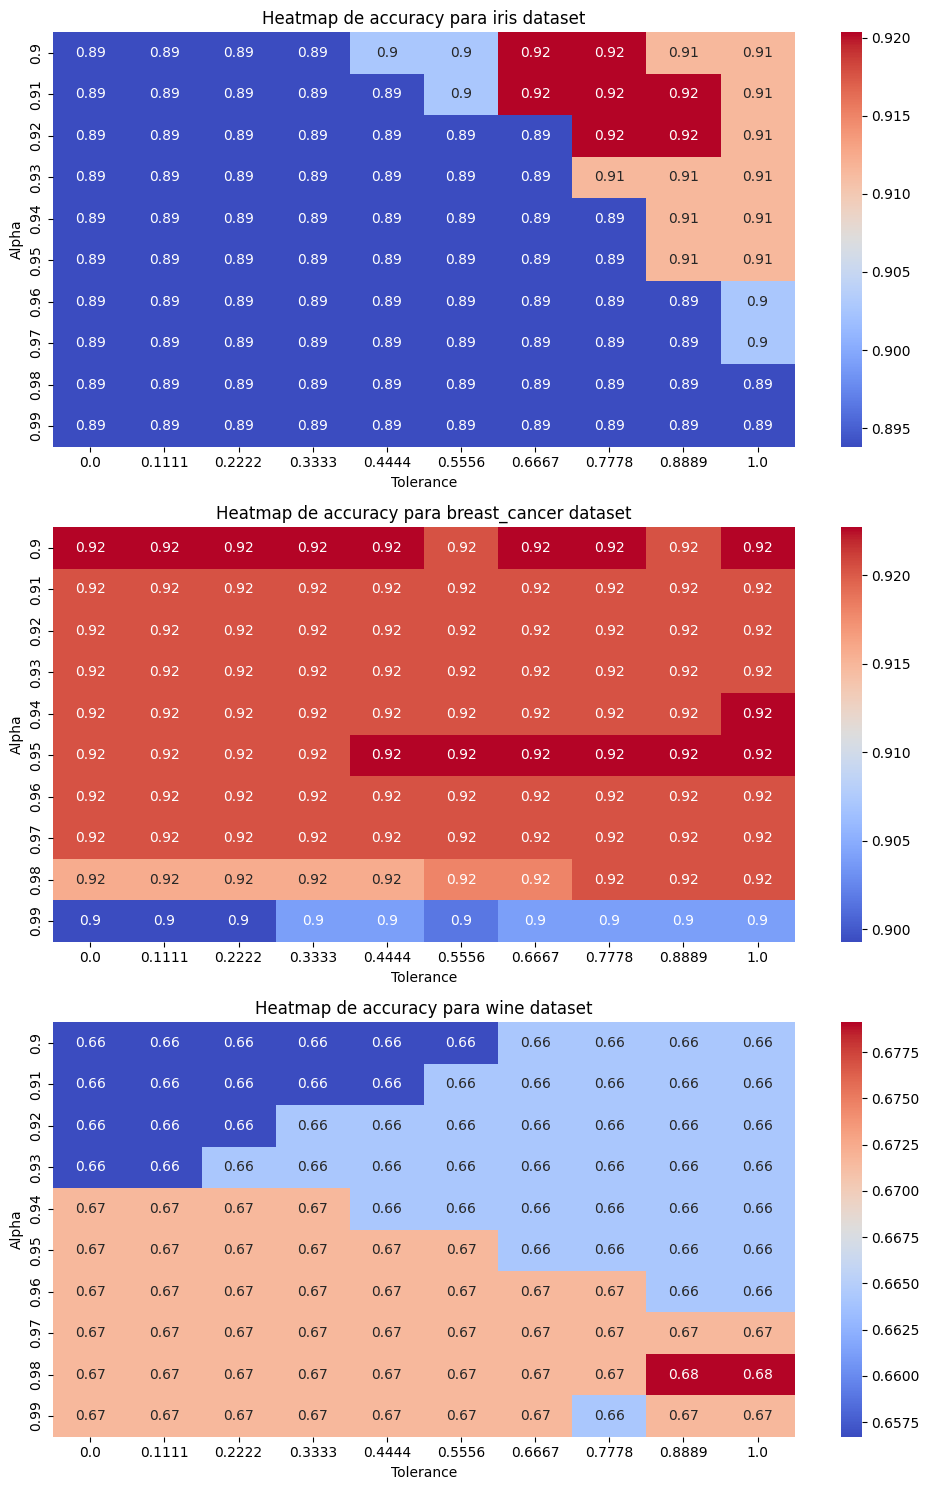

In [69]:
import matplotlib.pyplot as plt

# Crear una figura con 3 subtramas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Bucle sobre los conjuntos de datos
for ax, (name, dataset) in zip(axs, datasets.items()):
    x = dataset.data
    y = dataset.target
    
    L, U, L_, U_ = train_test_split(x, y, test_size=0.75, stratify=y)
    todas_etiquetas = np.concatenate((L_, U_))
    solver = Gbili(U, L, todas_etiquetas, K)
    grafo = solver.construir_grafo()

    # Estudio para alpha y tol
    results = np.zeros((len(alpha_values), len(tol_values)))

    for i, alpha in enumerate(alpha_values):
        for j, tol in enumerate(tol_values):
            inferecia = LGC(grafo, solver.nodos, solver.etiquetas_etiquetados, alpha=alpha, tol=tol, max_iter=10000)
            predicciones = inferecia.inferir_etiquetas()
            accuracy = np.mean(predicciones[len(L):] == todas_etiquetas[len(L):])
            results[i, j] = accuracy

    sns.heatmap(results, xticklabels=tol_values, yticklabels=alpha_values, annot=True, cmap='coolwarm', ax=ax)
    ax.set_xlabel('Tolerance')
    ax.set_ylabel('Alpha')
    ax.set_title(f'Heatmap de accuracy para {name} dataset')

# Ajustar el espacio entre las subtramas
plt.tight_layout()
plt.show()